In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision

In [3]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)
    
    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))

In [4]:
enc_block = Block(1, 64)
x         = torch.randn(1, 1, 572, 572)
enc_block(x).shape

torch.Size([1, 64, 568, 568])

torch.Size([1, 64, 568, 568])

In [5]:
class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs

In [6]:
encoder = Encoder()
# input image
x    = torch.randn(1, 3, 572, 572)
print(x.shape)
ftrs = encoder(x)
# for ftr in ftrs: print(ftr.shape)


# torch.Size([1, 64, 568, 568])
# torch.Size([1, 128, 280, 280])
# torch.Size([1, 256, 136, 136])
# torch.Size([1, 512, 64, 64])
# torch.Size([1, 1024, 28, 28])

torch.Size([1, 3, 572, 572])


In [7]:
class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

In [8]:
decoder = Decoder()
x = torch.randn(1, 1024, 28, 28)
decoder(x, ftrs[::-1][1:]).shape

torch.Size([1, 64, 388, 388])

torch.Size([1, 64, 388, 388])

In [9]:
# class UNet(nn.Module):
#     def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1, retain_dim=False, out_sz=(572,572)):
#         super().__init__()
#         self.encoder     = Encoder(enc_chs)
#         self.decoder     = Decoder(dec_chs)
#         self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
#         self.retain_dim  = retain_dim
#         self.out_sz = out_sz

#     def forward(self, x):
#         enc_ftrs = self.encoder(x)
#         out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
#         out      = self.head(out)
#         if self.retain_dim:
#             out = F.interpolate(out, self.out_sz)
#         return out

In [10]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)
    
    def forward(self, x):
        return self.conv2(self.relu(self.conv1(x)))


class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1, retain_dim=False, out_sz=(572,572)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim
        self.out_sz = out_sz

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, self.out_sz)
        return out

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=800x534 at 0x7FAA7273E6D0>


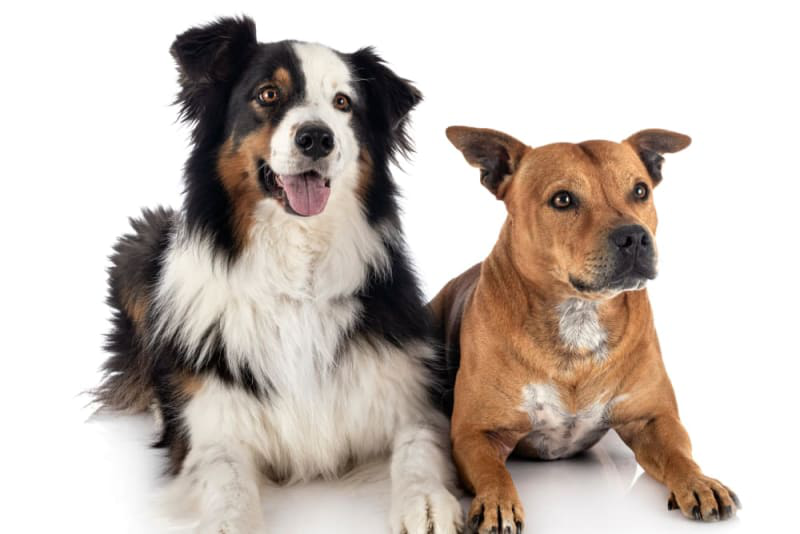

tensor([[[[255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          ...,
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.]],

         [[255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          ...,
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.]],

         [[255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          ...,
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ..., 255., 255., 255.],
          [255., 255., 255.,  ...

tensor([[[1.4425, 1.3441, 1.4426,  ..., 1.3441, 1.4426, 1.3445],
         [1.4173, 1.3890, 1.4170,  ..., 1.3890, 1.4170, 1.3878],
         [1.4426, 1.3447, 1.4408,  ..., 1.3447, 1.4408, 1.3430],
         ...,
         [1.4103, 1.3725, 1.4093,  ..., 1.3849, 1.4181, 1.3862],
         [1.4406, 1.3250, 1.4256,  ..., 1.3460, 1.4399, 1.3403],
         [1.4167, 1.3852, 1.4132,  ..., 1.3908, 1.4148, 1.3880]]],
       grad_fn=<ViewBackward0>)

Done


In [20]:
from  PIL import Image
import torchvision.transforms as transforms

img = Image.open("cat1.jpg")
img = Image.open("dog1.jpg")
# img = Image.open("dog3.jpg")
# img = Image.open("2dogs.jpg")
print(img)
display(img)
transform = transforms.Compose([transforms.PILToTensor()])

img_tensor = transform(img)
img_tensor = img_tensor.float()
img_tensor = img_tensor[None, :,:,:]

print(img_tensor)
print(type(img_tensor))
print(img_tensor.size())

unet = UNet()
out = unet.forward(img_tensor)
print(type(out))
print("SIZE:", out.size())
out_tensor = out.reshape((-1,)+out.shape[2:])
display(out_tensor)
transform = transforms.ToPILImage()
mask = transform(out_tensor)
mask.show()

print("Done")
